## Monte Carlo simulation of stable membrane curvatures

##### Using functions from mem_curve.py

In [2]:
# Standard imports
import matplotlib.pyplot as plt
import pandas as pd
import os
# For reading csv
import csv
import re
# For power spectrum
from scipy.signal import periodogram


# Custom imports
from mem_curve import *

### Running simulation, replica exchange, annealing

#### Simulation:
Initialise model membrane --  parametrised by Fourier series coefficients and over descrete grid -- run Monte Carlo for <$n$> steps using Helfrich bending energy


#### Fourier Surface:
$
h(x, y) =
\sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \alpha_{n,m} \cos\left(\frac{2\pi n x}{l_x}\right) \cos\left(\frac{2\pi m y}{l_y}\right)
+ \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \beta_{n,m} \cos\left(\frac{2\pi n x}{l_x}\right) \sin\left(\frac{2\pi m y}{l_y}\right)
+ \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \gamma_{n,m} \sin\left(\frac{2\pi n x}{l_x}\right) \cos\left(\frac{2\pi m y}{l_y}\right)
+ \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \zeta_{n,m} \sin\left(\frac{2\pi n x}{l_x}\right) \sin\left(\frac{2\pi m y}{l_y}\right)
$

In [3]:
# Choose number of Monte Carlo steps
nsteps = 60000

# Choose directory to save/ load
save_dir = 'trial_doublebuckled'
os.makedirs(f'./{save_dir}/', exist_ok=True)

In [13]:
# Initialise membrane ensemble

# Custom initial membrane
membrane_start = {'alpha' : np.zeros((params.exp_order, params.exp_order)),
                  'beta'  : np.zeros((params.exp_order, params.exp_order)),
                  'gamma' : np.zeros((params.exp_order, params.exp_order)),
                  'zeta'  : np.zeros((params.exp_order, params.exp_order))}

#membrane_start['gamma'][2,0] = 1 #  sine wave in x-direction
membrane_start['zeta'][2,2] = 1  #  wave in both x,y-directions

membrane_lst = [ init_model_membrane( membrane_start ) ]

Initial membrane bending energy: 99.13521750996922 kbT , excess area: 39.09592906052694


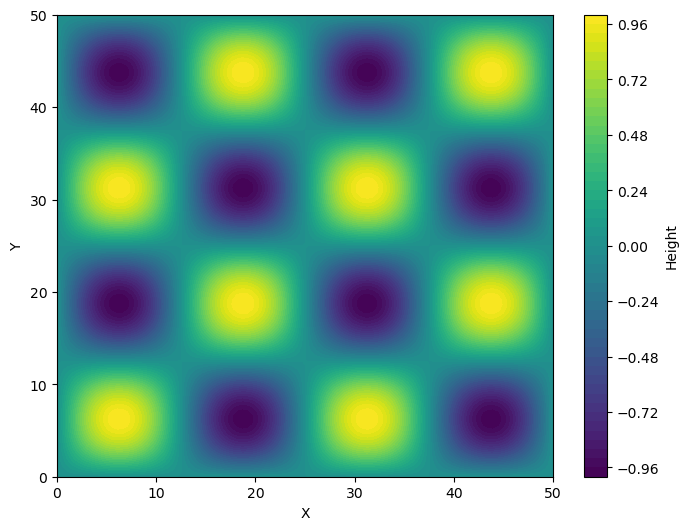

In [6]:
# Visualise starting surface
contour_surface_plot(membrane_start, filename=f'./{save_dir}/start_surface')

In [7]:
# Track acceptance probability
naccepts       = 0
naccepts_track = []

# Header for prints
print(f"{'Step':<9} {'Accepted Moves':<18} {'Bending Energy (kbT)':<15}\n{'-'*50}")

# Run simulation
for step in range(1,nsteps+1):
    
    membrane_lst, accept_move = montecarlostep(membrane_lst)

    naccepts += 1 if accept_move else 0
    naccepts_track += [naccepts]
    
    if step%100==0 and step!=0:
        print(f"{step:<9} {naccepts:<18} {membrane_lst[-1]['energy']:<15.2f}")

print('Acceptance ratio:', naccepts/nsteps)

Step      Accepted Moves     Bending Energy (kbT)
--------------------------------------------------
100       100                139.22         
200       200                109.41         
300       300                123.94         
400       400                114.38         
500       500                105.18         


KeyboardInterrupt: 

In [8]:
# Save data to a csv
df = pd.DataFrame(membrane_lst)

df.to_csv(f'./{save_dir}/model_membranes.csv', index=False)

### Load data from saved csv

In [15]:
def string_to_array(s):
    s_clean = re.sub(r'[\[\]]', '', s)
    if ' ' not in s_clean:
        return float(s_clean)
    return np.array([[float(x) for x in line.split() if x]
                     for line in s_clean.strip().split('\n')])

with open(f'./{save_dir}/model_membranes.csv', mode='r', newline='') as file:
    reader = csv.DictReader(file)
    membrane_lst = []
    for row in reader:
        parsed_row = {}
        for key, val in row.items():
            parsed_row[key] = string_to_array(val)
        membrane_lst.append(parsed_row)

### Data Analysis

#### Equilibration

How does ratio of accepted moves evolve?

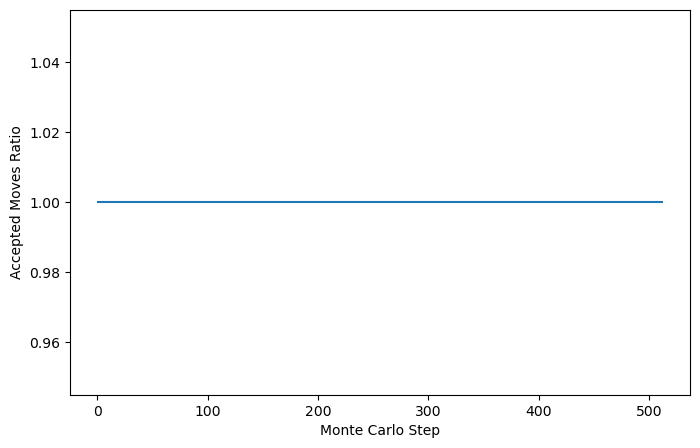

In [9]:
# note: won't work if data has been loaded
mcsteps_arr = np.linspace(1,len(naccepts_track),len(naccepts_track))
ratio_arr = np.array(naccepts_track)/mcsteps_arr

plt.figure(figsize=[8,5])
plt.ylabel('Accepted Moves Ratio')
plt.xlabel('Monte Carlo Step')
plt.plot(mcsteps_arr, ratio_arr)
plt.savefig(f'./{save_dir}/naccepts.pdf')
plt.show()

#### Plot bending energy vs Monte Carlo step

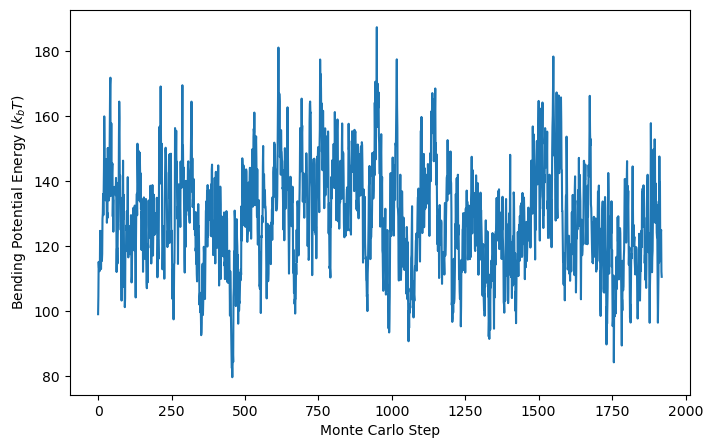

In [10]:
# Extract bending energy from membrane_lst of dictionaries
energy_lst = [ membrane['energy'] for membrane in membrane_lst ]

# Plot energy
plt.figure(figsize=[8,5])
plt.ylabel('Bending Potential Energy ($k_bT$)')
plt.xlabel('Monte Carlo Step')
plt.plot(range(len(energy_lst)), energy_lst)
plt.savefig(f'./{save_dir}/bending_energy.pdf')
plt.show()

#### Plot mean & Gaussian curvature vs Monte Carlo step

In [8]:
# Calculate values every <nframes>
nframes = 100

H_lst  = []
K_lst  = []
dA_lst = []

for membrane in membrane_lst[::nframes]:

    # Calculate local height derivatives from Fourier surface
    h_x, h_y, h_xx, h_xy, h_yy = calc_fourier_derivatives(membrane, params.X, params.Y)
    # Calculate shape operator
    S = calc_shape_operator(h_x, h_y, h_xx, h_xy, h_yy)
    
    # Calculate mean and Gaussian curvatures
    H_lst += [np.sum(calc_H(S))]
    K_lst += [np.sum(calc_K_G(S))] 

    # Calculate change in area from membrane bending
    dA_lst += [np.sum(calc_area_element(h_x, h_y))/params.npts**2]

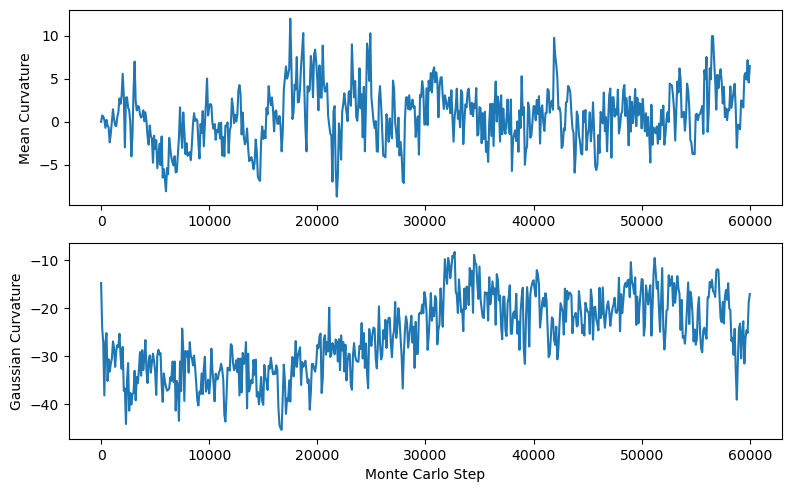

In [9]:
plt.figure(figsize=[8,5])

# Plot mean curvature
plt.subplot(2, 1, 1)
plt.ylabel('Mean Curvature')
#plt.xlabel('Monte Carlo Step')
plt.plot(range(0,len(membrane_lst),nframes), H_lst)
#plt.savefig(f'./{save_dir}/mean_curvature.pdf')
#plt.show()

# Plot Gaussian curvature
#plt.figure(figsize=[8,5])
plt.subplot(2, 1, 2)
plt.ylabel('Gaussian Curvature')
plt.xlabel('Monte Carlo Step')
plt.plot(range(0,len(membrane_lst),nframes), K_lst)
#plt.savefig(f'./{save_dir}/Gaussian_curvature.pdf')

plt.tight_layout(pad=1)
plt.savefig(f'./{save_dir}/curvatures.pdf')
plt.show()

#### Box Size

Not change explicitly - derivatives using Fourier coefficients still using raw length - but for in energy calculation

Starting surface area: 2539
Excess area:           39 +- 2



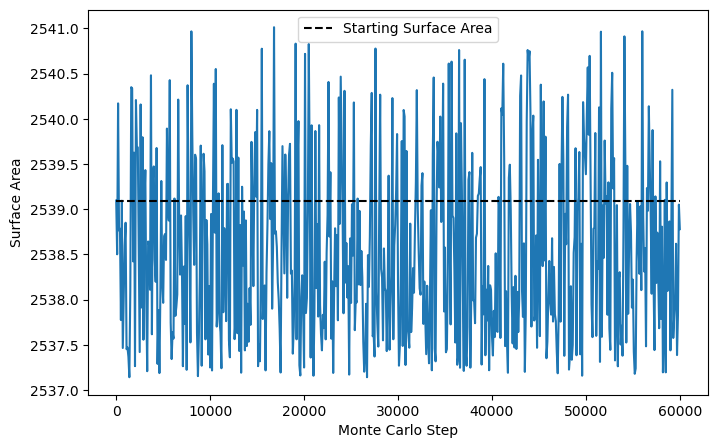

In [25]:
# Starting surface area
sa_start = params.original_excess_area + params.l_x*params.l_y

print(f'''Starting surface area: {sa_start:.0f}
Excess area:           {params.original_excess_area:.0f} +- {params.original_excess_area*params.dA_threshold:.0f}''')

# Plot dA from curvature
plt.figure(figsize=[8,5])
plt.ylabel('Surface Area')
plt.xlabel('Monte Carlo Step')
plt.plot(range(0,len(membrane_lst),nframes), dA_lst)
plt.hlines(sa_start, 0, len(membrane_lst), linestyle='--', color='k', label='Starting Surface Area')
plt.legend(loc='best')
plt.savefig(f'./{save_dir}/surfacearea.pdf')
plt.show()

#### Take mean of height 
From equilibrium sampled region

Is average membrane structure flat?

#### Take mean squared height
How does membrane thickness compare to CWT..?

$\langle h(\textbf{r})^{2} \rangle = \frac{k_bT}{16\pi^{3} \kappa} L^{2} $

In [ ]:
# Skip steps before equilibrium
nskip = 10000

# Calculate values every <nframes>
nframes = 10

# Simulated values
mean_height   = 0 
meansq_height = 0 

# Theoretical value (from Capillary Wave Theory on membranes)
cwt_meansq_h = params.kbT / (16 * np.pi**3 * params.kappa_H) * params.l_x * params.l_y

In [ ]:
for membrane in membrane_lst[nskip::nframes]:

    # Calculate height
    mem_height     = calc_height(membrane, params.X, params.Y)
    mean_height   += np.mean(mem_height) # average over all grids
    #meansq_height += ( (np.max(mem_height) - np.min(mem_height))/2 )**2 # take membrane height from the mid-plane, average of +VE & -VE deviations
    meansq_height += np.mean(mem_height**2)
    
mean_height   /= len(membrane_lst[nskip::nframes])
meansq_height /= len(membrane_lst[nskip::nframes])

In [42]:
print(f'''
<h> = {mean_height} (simulated)
<h> = 0.0 (CWT)

<h^2> = {meansq_height} (simulated) 
<h^2> = {cwt_meansq_h} (CWT)''')


<h> = 1.6108319795103154 (simulated)
<h> = 0.0 (CWT)

<h^2> = 7.056119713908815 (simulated) 
<h^2> = 0.25196511275937106 (CWT)


#### Histogram of curvatures

In [ ]:
plt.figure(figsize=[8,5])
plt.ylabel('Frequency')
plt.xlabel('Bending Energy')
plt.hist(energy_lst, bins=100)
plt.savefig(f'./{save_dir}/Helfrich_bin.pdf')
plt.show()

plt.figure(figsize=[8,5])
plt.ylabel('Frequency')
plt.xlabel('Mean Curvature')
plt.hist(H_lst, bins=100)
plt.savefig(f'./{save_dir}/mean_bin.pdf')
plt.show()

plt.figure(figsize=[8,5])
plt.ylabel('Frequency')
plt.xlabel('Gaussian Curvature')
plt.hist(K_lst, bins=100)
plt.savefig(f'./{save_dir}/Gaussian_bin.pdf')
plt.show()

#### Mean Fourier Coefficients

$
h(x, y) =
\sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \alpha_{n,m} \cos\left(\frac{2\pi n x}{l_x}\right) \cos\left(\frac{2\pi m y}{l_y}\right)
+ \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \beta_{n,m} \cos\left(\frac{2\pi n x}{l_x}\right) \sin\left(\frac{2\pi m y}{l_y}\right)
+ \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \gamma_{n,m} \sin\left(\frac{2\pi n x}{l_x}\right) \cos\left(\frac{2\pi m y}{l_y}\right)
+ \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} \zeta_{n,m} \sin\left(\frac{2\pi n x}{l_x}\right) \sin\left(\frac{2\pi m y}{l_y}\right)
$


In [14]:
nskip = 0

# Calculate mean Fourier coefficients
alpha_lst, beta_lst, gamma_lst, zeta_lst = [], [], [], []

for membrane in membrane_lst[nskip:]:
    alpha_lst += [membrane['alpha']]
    beta_lst  += [membrane['beta']]
    gamma_lst += [membrane['gamma']]
    zeta_lst  += [membrane['zeta']]

alpha_mean = np.mean(alpha_lst, axis=0)
beta_mean  = np.mean(beta_lst,  axis=0)
gamma_mean = np.mean(gamma_lst, axis=0)
zeta_mean  = np.mean(zeta_lst,  axis=0)

Fcoeff_means = [alpha_mean, beta_mean, gamma_mean, zeta_mean]

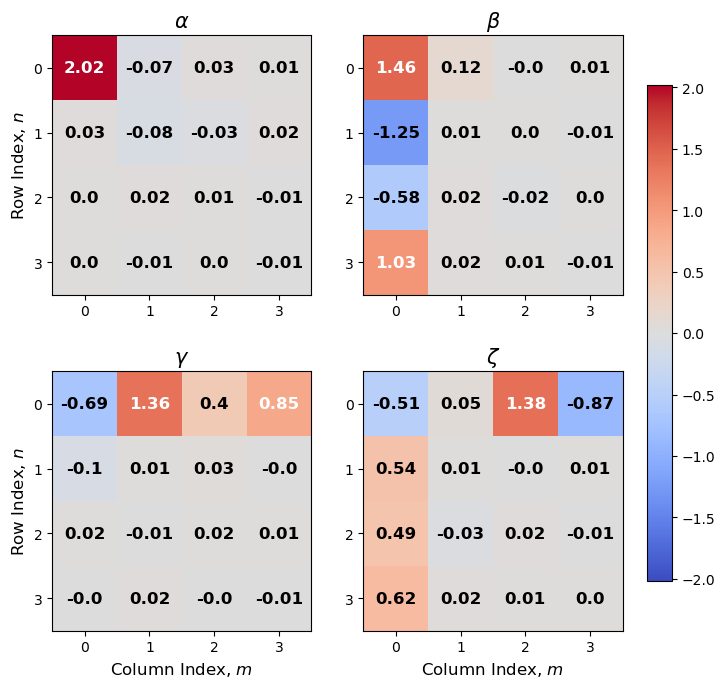

In [15]:
# Plot mean Fourier coeff values
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

titles = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\zeta$']

# find maximum absolute value for colourbar reference
maxval = np.max(Fcoeff_means) if np.max(Fcoeff_means)>abs(np.min(Fcoeff_means)) else abs(np.min(Fcoeff_means))

for idx, (ax, cm) in enumerate(zip(axes, Fcoeff_means)):
    im = ax.imshow(cm, cmap='coolwarm', vmin=-maxval, vmax=maxval)
    ax.set_title(titles[idx], fontsize=15)

    # Annotate each cell
    for i in range(params.exp_order):
        for j in range(params.exp_order):
            ax.text(j, i, f'{round(Fcoeff_means[idx][i,j],2)}',
                    ha='center', va='center',
                    color='white' if cm[i, j] > cm.max() / 2 else 'black',
                    fontsize=12, fontweight='bold')

    ax.set_xticks(range(params.exp_order))
    ax.set_yticks(range(params.exp_order))
    if idx in [2,3]:
        ax.set_xlabel(r'Column Index, $m$', fontsize=12)
    if idx in [0,2]:
        ax.set_ylabel(r'Row Index, $n$', fontsize=12)

# Add a shared colorbar
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.04, pad=0.04)
#cbar.set_label('Mean Fourier Coefficient Value', fontsize=13)

#plt.tight_layout(pad=2)
plt.savefig(f'./{save_dir}/Fcoeff.pdf')
plt.show()

#### Power Spectrum

In [14]:
# Calculate power spectrum
f, Pxx = periodogram(energy_lst)

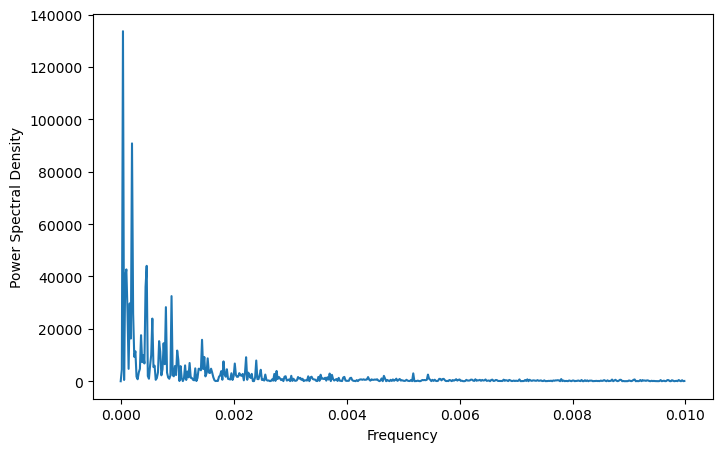

In [15]:
upto = 500
plt.figure(figsize=[8,5])
plt.ylabel('Power Spectral Density')
plt.xlabel('Frequency')
plt.plot(f[:upto], Pxx[:upto])
plt.savefig(f'./{save_dir}/pwr_spectral_dens.pdf')
plt.show()

#### Visualising membrane curvature

In [17]:
# Set plots as pop-ups
%matplotlib qt

In [16]:
myvis = visualise(membrane_lst, nframes=50, save_dir=save_dir)

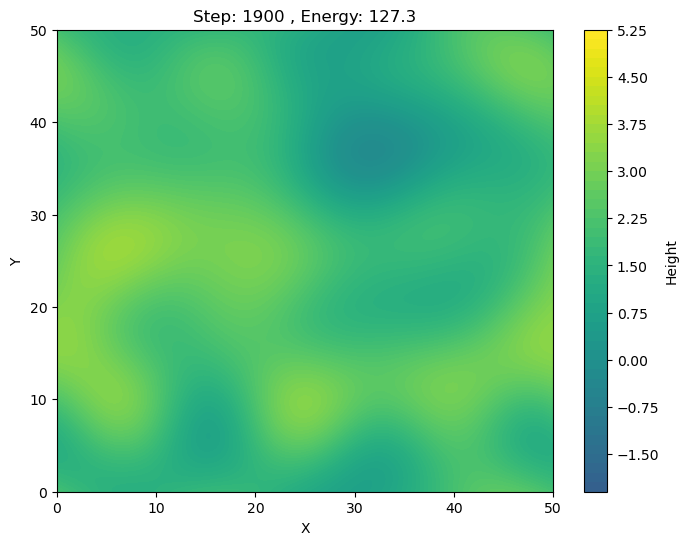

In [17]:
# Visualise membrane curvatures with contour plot movie
myvis.vis_contour()

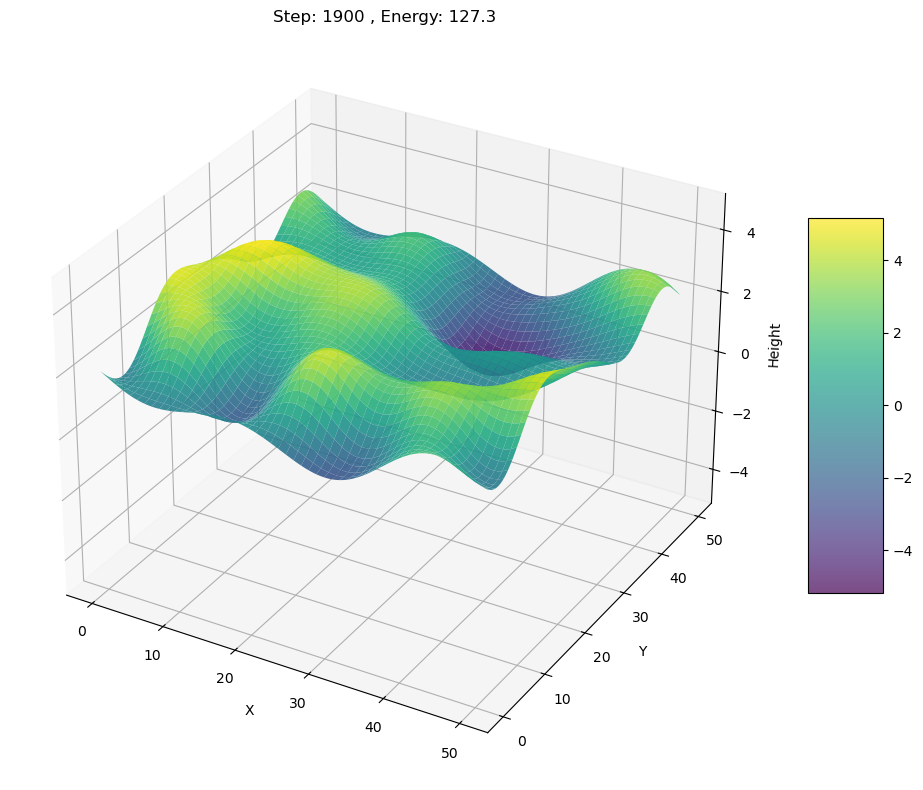

In [18]:
# Visualise membrane curvatures with 3D surface plot movie
myvis.vis_3d()

In [19]:
# Set plots to in line
%matplotlib inline

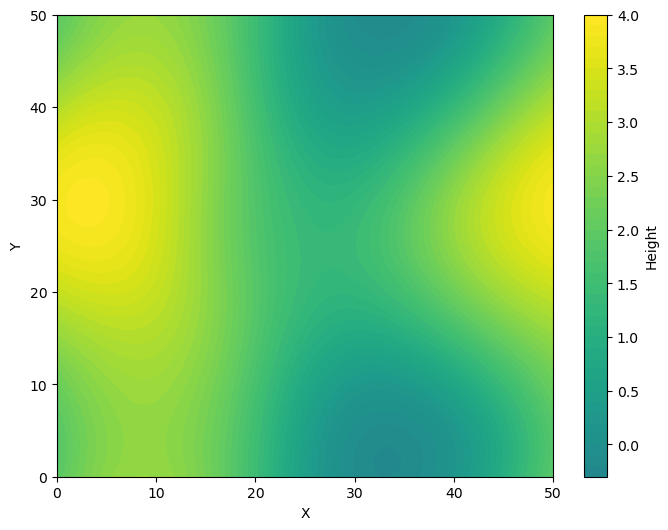

In [20]:
# Visualise 'mean surface'

mean_membrane = {
    'alpha' : alpha_mean,
    'beta'  : beta_mean,
    'gamma' : gamma_mean,
    'zeta'  : zeta_mean} 

contour_surface_plot(mean_membrane, filename=f'./{save_dir}/mean_surface')

### Save logging info

In [ ]:
log_str = f'''
# # # Parameters # # #

Box parameters:
l_x       = {params.l_x}    # Box size, x-direction
l_y       = {params.l_y}    # Box size, y-direction
exp_order = {params.exp_order}     # Order of 2D Fourier expansion
npts      = {params.npts}    # Number of points in each unit l_x, l_y for grid calculations

Bending energies:
H_0     = {params.H_0}     # Optimum mean curvature
kappa_H = {params.kappa_H}     # Bending modulus of mean curvature (kbT units)
kappa_K = {params.kappa_K}     # Bending modulus of Gaussian curvature (kbT units)

Size of Monte Carlo moves:
delta = {params.delta}     # Standard deviation of perturbation applied to Fourier coefficients

Maximum change in projected area
Original excess area = {params.original_excess_area}     # placeholder for later calculation
dA_threshold         = {params.dA_threshold}  # Fraction change allowed from starting membrane

Number of steps:
nsteps = {nsteps}


# # # Results # # #

Acceptance ratio   = {naccepts/nsteps}

Curvature:
Bending energy     = {np.mean(energy_lst[int(nskip/nframes):])}
Mean curvature     = {np.mean(H_lst[int(nskip/nframes):])}
Guassian curvature = {np.mean(K_lst[int(nskip/nframes):])}

Membrane height:
mean height = {mean_height} (simulated)
mean height = 0.0                   (CWT)
mean squared height = {meansq_height} (simulated)
mean squared height = {cwt_meansq_h} (CWT)

Note: averages after {nskip} steps
'''

filename = f"./{save_dir}/log.txt"

# Write the string to the file
with open(filename, "w") as file:
    file.write(log_str)

print(f'Log file saved as {filename}')

### Test finite size & boundary artifacts

In [27]:
os.makedirs(f'./{save_dir}/errortest', exist_ok=True)

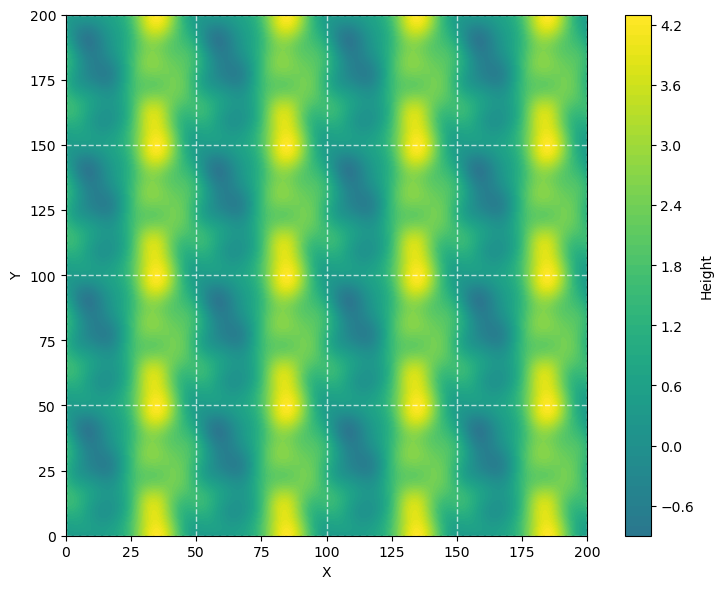

In [23]:
# Visualise 'mean surface' over multiple box lengths
nboxes = 4
npts = 100
x = np.linspace(0, params.l_x*nboxes, npts*nboxes)
y = np.linspace(0, params.l_y*nboxes, npts*nboxes)
X, Y = np.meshgrid(x, y)

# Choose membrane
mymembrane = membrane_lst[30000] # mean_membrane
Z = calc_height(mymembrane, X, Y)

# Figure setup
fig, ax = plt.subplots(figsize=[8, 6])

# Contour plot
maxval = np.max(Z) if np.max(Z) > abs(np.min(Z)) else abs(np.min(Z))
contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis', vmin=-maxval, vmax=maxval)
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label("Height")

# Axis labels
ax.set_xlabel("X")
ax.set_ylabel("Y")

# grid lines at multiples of box length
for i in range(nboxes+1):  # 0 to 4 boxes
    ax.axvline(x=i * params.l_x, color='white', lw=1.0, ls='--', alpha=0.7)
    ax.axhline(y=i * params.l_y, color='white', lw=1.0, ls='--', alpha=0.7)

# make sure the grid lines appear on top
ax.set_axisbelow(False)

# clean styling
ax.set_xlim(0, params.l_x * 4)
ax.set_ylim(0, params.l_y * 4)
ax.set_aspect('equal')  # Square cells if physical lengths match
  
plt.tight_layout()
plt.savefig(f'./{save_dir}/errortest/periodic_surface.pdf')
plt.show()

#### Periodic box boundary position!

Grid over which energy is calculated vs for simulation results in changes in energy

Artifact! However, smooths out when taken over many MC frames.

Likely derives from innaccuracies from descretisation

In [30]:
# Choose data
mymembrane_lst = membrane_lst[::10000] # selection of membranes
t = 200 # number of translation points


# Box size
l_x, l_y = params.l_x, params.l_y
# note: if differs from simulation box size, will have superposition of boundary effects


# Initialise data holders
dA_bd_lst = np.zeros( (len(mymembrane_lst), t) )
U_bd_lst  = np.zeros( (len(mymembrane_lst), t) )
H_bd_lst  = np.zeros( (len(mymembrane_lst), t) )
K_bd_lst  = np.zeros( (len(mymembrane_lst), t) )

for i, mymembrane in enumerate(mymembrane_lst):

    for n in range(0,t):
    
        m = t - n
    
        # X, Y grid for calculations
        npts = 4     
        x = np.linspace(n*l_x/t, m*l_x/t, l_x * npts)
        y = np.linspace(n*l_y/t, m*l_y/t, l_y * npts)
        X, Y = np.meshgrid(x, y)
        
        # Calculate local height derivatives from Fourier surface
        h_x, h_y, h_xx, h_xy, h_yy = calc_fourier_derivatives(mymembrane, X, Y)
        # Calculate shape operator
        S = calc_shape_operator(h_x, h_y, h_xx, h_xy, h_yy)
        # Calculate change in area from membrane bending
        dA = calc_area_element(h_x, h_y)
        # Calculate mean and Gaussian curvatures
        H   = calc_H(S)
        K_G = calc_K_G(S)
        # Calculate bending energy, from 'calc_helfrich_energy'
        energy_per_l = 2*params.kappa_H * ( H - params.H_0 )**2 + abs(params.kappa_K * K_G) # abs to avoid negative bending energy??
        subgrid_area = 1 / (dA * npts**2) 
        bending_energy = np.sum(energy_per_l * subgrid_area)

        # Save data
        dA_bd_lst[i,n] = np.sum(dA)/npts**2
        H_bd_lst [i,n] = np.sum(H)
        K_bd_lst [i,n] = np.sum(K_G)
        U_bd_lst [i,n] = bending_energy

dA_bd_means = np.mean(dA_bd_lst, axis=0)
H_bd_means  = np.mean(H_bd_lst,  axis=0)
K_bd_means  = np.mean(K_bd_lst,  axis=0)
U_bd_means  = np.mean(U_bd_lst,  axis=0)

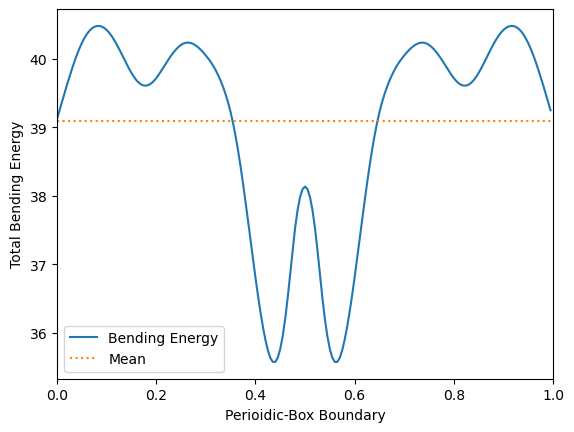

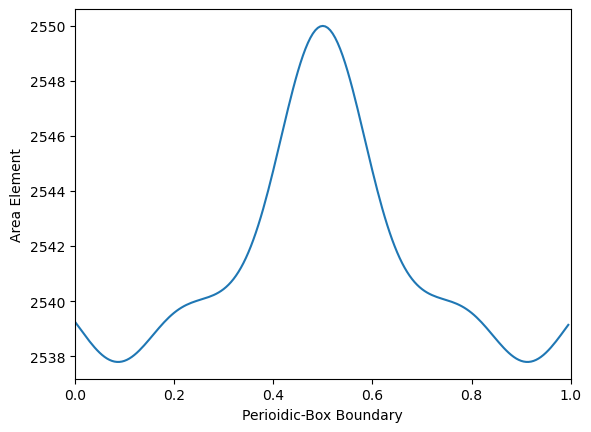

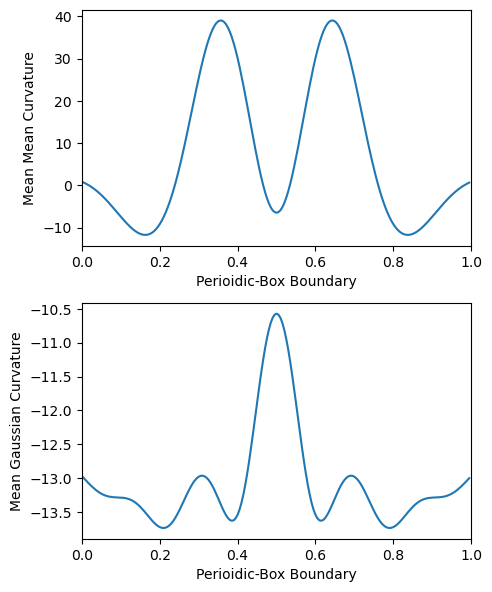

In [31]:
plt.figure()

plt.ylabel('Total Bending Energy')
plt.xlabel('Perioidic-Box Boundary')
plt.plot(np.arange(t)/t, U_bd_means, label='Bending Energy')
plt.plot( [0,1], [np.mean(U_bd_means)]*2 , linestyle=':', label='Mean')
plt.hline()
plt.xlim(0,1)
plt.legend(loc='best')

plt.savefig(f'./{save_dir}/errortest/boundary_vs_energy.pdf')
plt.show()


plt.figure()

plt.ylabel('Area Element')
plt.xlabel('Perioidic-Box Boundary')
plt.plot(np.arange(t)/t, dA_bd_means)
plt.xlim(0,1)

plt.savefig(f'./{save_dir}/errortest/boundary_vs_dA.pdf')
plt.show()


plt.figure(figsize=[5,6])

plt.subplot(2,1,1)
plt.ylabel('Mean Mean Curvature')
plt.xlabel('Perioidic-Box Boundary')
plt.plot(np.arange(t)/t, H_bd_means)
plt.xlim(0,1)

plt.subplot(2,1,2)
plt.ylabel('Mean Gaussian Curvature')
plt.xlabel('Perioidic-Box Boundary')
plt.plot(np.arange(t)/t, K_bd_means)
plt.xlim(0,1)

plt.tight_layout(pad=1)
plt.savefig(f'./{save_dir}/errortest/boundary_vs_curve.pdf')
plt.show()

#### Periodic Box Size

No issues! - Linear relationship between square root of total bending energy to box side length

Note: 'dimple' due to periodic boundary effect

In [ ]:
# Choose data
mymembrane = membrane_lst[100]

U_lst = []
t_max = 200
t_range = np.arange(1, t_max+1)

for n in t_range:
    # X, Y grid for calculations
    l_x = 1 * n
    l_y = 1 * n!
    
    npts = 2
    x = np.linspace(0, l_x, l_x * npts)
    y = np.linspace(0, l_y, l_y * npts)
    X, Y = np.meshgrid(x, y)
    
    # Calculate local height derivatives from Fourier surface
    h_x, h_y, h_xx, h_xy, h_yy = calc_fourier_derivatives(mymembrane, X, Y)
    # Calculate shape operator
    S = calc_shape_operator(h_x, h_y, h_xx, h_xy, h_yy)
    # Calculate change in area from membrane bending
    dA = calc_area_element(h_x, h_y)
    # Calculate mean and Gaussian curvatures
    H   = calc_H(S)
    K_G = calc_K_G(S)
    # Calculate bending energy
    # from 'calc_helfrich_energy'
    energy_per_l = 2*params.kappa_H * ( H - params.H_0 )**2 + abs(params.kappa_K * K_G) # abs to avoid negative bending energy??
    subgrid_area = 1 / (dA * npts**2) # for integration over total area: l_x * l_y / ( l_x*npts * l_y*npts )
    bending_energy = np.sum(energy_per_l * subgrid_area)
    
    U_lst += [bending_energy]

The gradient of sqrt total energy w/ respect to box l is 0.17306208278274945, or 8.653104139137472 per box


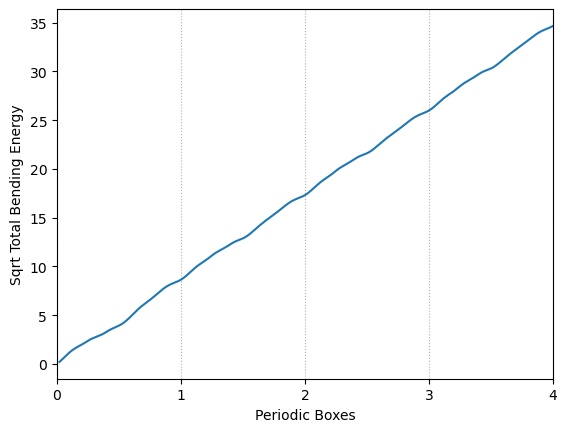

In [68]:
grad_U_vs_l = (np.sqrt(U_lst[-1])-np.sqrt(U_lst[0])) / (t_range[-1]-t_range[0])
print(f'The gradient of sqrt total energy w/ respect to box l is {grad_U_vs_l}, or {grad_U_vs_l*params.l_x} per box')

plt.figure()
plt.ylabel('Sqrt Total Bending Energy')
plt.xlabel('Periodic Boxes')
plt.plot(t_range, np.sqrt(U_lst))
plt.grid(linestyle=':', axis='x')
plt.xticks(np.arange(0, t_max+1, params.l_x),[str(n) for n in range(len(range(0, t_max+1, params.l_x)))])
plt.xlim(0, t_max)
plt.savefig(f'./{save_dir}/errortest/boxsize_vs_energy.pdf')
plt.show()

# Grid division -- number of integration points per unit length
No issues!

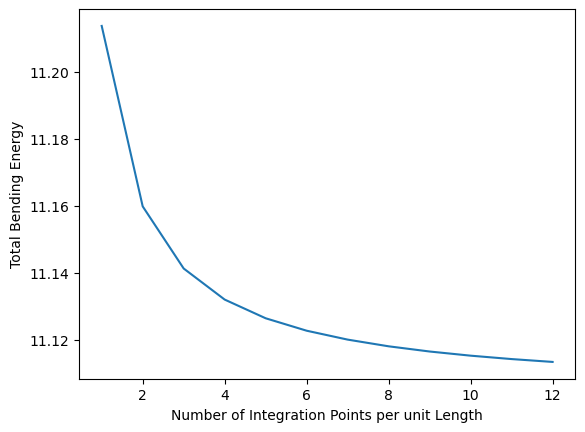

In [36]:
# Choose data
mymembrane = membrane_lst[100]

U_lst = []
npts_range = range(1, 12+1)

l_x = l_y = 50
# note: if differs from simulation box size, will have superposition of boundary effects

for npts in npts_range:

    # X, Y grid for calculations   
    x = np.linspace(0, l_x, l_x * npts)
    y = np.linspace(0, l_y, l_y * npts)
    X, Y = np.meshgrid(x, y)
    
    # Calculate local height derivatives from Fourier surface
    h_x, h_y, h_xx, h_xy, h_yy = calc_fourier_derivatives(mymembrane, X, Y)
    # Calculate shape operator
    S = calc_shape_operator(h_x, h_y, h_xx, h_xy, h_yy)
    # Calculate mean and Gaussian curvatures
    H   = calc_H(S)
    K_G = calc_K_G(S)
    # Calculate bending energy
    # from 'calc_helfrich_energy'
    energy_per_l = 2*params.kappa_H * ( H - params.H_0 )**2 + abs(params.kappa_K * K_G) # abs to avoid negative bending energy??
    subgrid_area = 1 / (npts**2) # for integration over total area: l_x * l_y / ( l_x*npts * l_y*npts )
    bending_energy = np.sum(energy_per_l) * subgrid_area
    
    U_lst += [bending_energy]

plt.figure()
plt.ylabel('Total Bending Energy')
plt.xlabel('Number of Integration Points per unit Length')
plt.plot(npts_range, U_lst)
plt.savefig(f'./{save_dir}/errortest/gridsize_vs_energy.pdf')
plt.show()

#### Area Correction

In [25]:
energy_uncorrected = []
energy_A_corrected = []

nframes = 10

for membrane in membrane_lst[::nframes]:
    # Calculate local height derivatives from Fourier surface
    h_x, h_y, h_xx, h_xy, h_yy = calc_fourier_derivatives(membrane, params.X, params.Y)
    
    # Calculate shape operator
    S = calc_shape_operator(h_x, h_y, h_xx, h_xy, h_yy)

    # Calculate change in area from membrane bending
    dA = calc_area_element(h_x, h_y)
    
    # Calculate mean and Gaussian curvatures
    H   = calc_H(S)
    K_G = calc_K_G(S)
    
    # Calculate bending energy
    energy_uncorrected += [calc_Helfrich_energy(H, K_G, dA=1)] # set dA=0 to ignore
    energy_A_corrected += [calc_Helfrich_energy(H, K_G, dA)]

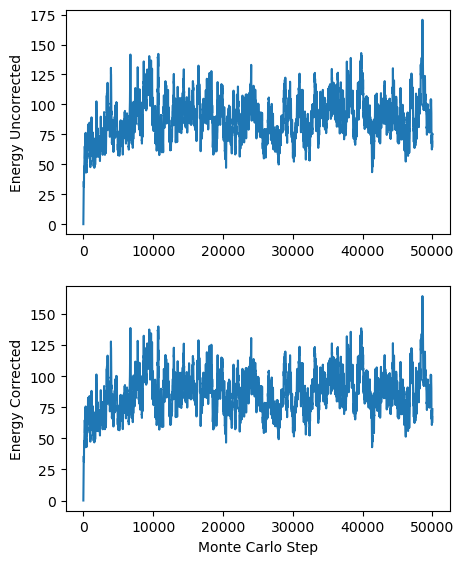

In [26]:
plt.figure(figsize=[5,6])

plt.subplot(2,1,1)
plt.ylabel('Energy Uncorrected')
#plt.xlabel('Monte Carlo Step')
plt.plot(range(0,nsteps+1,nframes), energy_uncorrected)

plt.subplot(2,1,2)
plt.ylabel('Energy Corrected')
plt.xlabel('Monte Carlo Step')
plt.plot(range(0,nsteps+1,nframes), energy_A_corrected)

plt.tight_layout(pad=2)
plt.show()

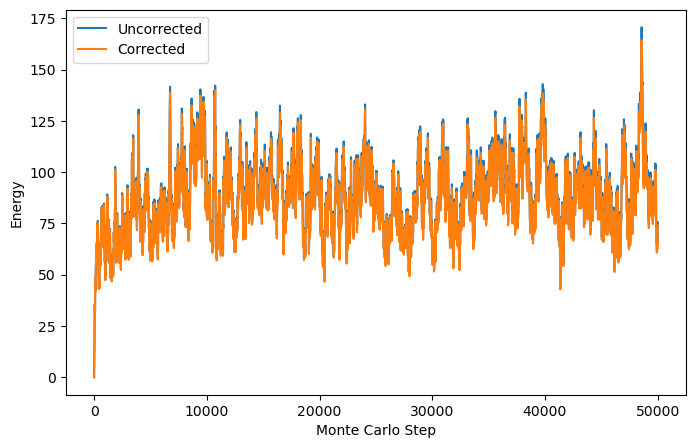

In [37]:
plt.figure(figsize=[8,5])

plt.ylabel('Energy')
plt.xlabel('Monte Carlo Step')
plt.plot(range(0,nsteps+1,nframes), energy_uncorrected, label='Uncorrected')
plt.plot(range(0,nsteps+1,nframes), energy_A_corrected, label='Corrected')
plt.legend(loc='best')

plt.savefig(f'./{save_dir}/errortest/dA_vs_energy.pdf')
plt.show()